# Libraries

In [51]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from sklearn.exceptions import ConvergenceWarning
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from transformers import GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification, BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from ml_things import plot_dict, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from joblib import dump
from joblib import load
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Preprocessing

- <strong>count</strong>: number of CrowdFlower users who coded each tweet
- <strong>hate_speech</strong>: number of CF users who judged the tweet to be hate speech
- <strong>offensive_language</strong>: number of CF users who judged the tweet to be offensive
- <strong>neither</strong>: number of CF users who judged the tweet to be neither offensive nor non-offensive
- <strong>class</strong>: class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
- <strong>tweet</strong>: text tweet

In [52]:
# Tensorboard initialization
writer = SummaryWriter(log_dir="./logs")

def parse_tweets_until_colon(data):
    parsed_tweets = []
    for tweet in data['tweet']:
        colon_index = tweet.find(':')
        if colon_index != -1:
            parsed_tweets.append(tweet[colon_index + 1:])
        else:
            parsed_tweets.append(tweet)
    return parsed_tweets

data = pd.read_csv('labeled_data.csv')
data = data.drop(columns='Unnamed: 0')
data['tweet'] = parse_tweets_until_colon(data)

data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,As a woman you shouldn't complain about clean...
1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat h...
2,3,0,3,0,1,You ever fuck a bitch and she start to cry? Y...
3,3,0,2,1,1,@viva_based she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or i...


# Text cleaning

- <strong>Lowercasing</strong>: Convert all text to lowercase to ensure uniformity.
- <strong>Removing Punctuation</strong>: Eliminate punctuation marks as they often don't carry much meaning in NLP tasks.
- <strong>Removing Special Characters</strong>: Remove special characters, emojis, URLs, etc., which may not contribute to the task at hand.
- <strong>Removing Stopwords</strong>: Stopwords are common words (e.g., "the", "is", "and") that occur frequently but often carry little information. Removing them can reduce noise in the data.

In [53]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

def clean_text(data):
    cleaned_tweets = []
    for tweet in data:
        tweet = tweet.lower()  # Convert text to lowercase
        tweet = re.sub(r"[^\w\s]", "", tweet)  # Remove punctuation
        tweet = re.sub(r"\d+", "", tweet)  # Remove numbers
        tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra whitespaces
        cleaned_tweets.append(tweet)
    return cleaned_tweets

def remove_stopwords(data):
    nostopwords_tweets = []
    for tweet in data:
        tokens = word_tokenize(tweet)  # Tokenize text
        stop_words = set(stopwords.words("english"))
        filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        filtered_text = " ".join(filtered_tokens)  # Join tokens back into a string
        nostopwords_tweets.append(filtered_text)
    return nostopwords_tweets

def apply_stemming(data):
    stemmer = PorterStemmer()
    stemmed_tweets = []
    for tweet in data:
        tokens = word_tokenize(tweet)  # Tokenize text
        stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Apply stemming
        stemmed_text = " ".join(stemmed_tokens)  # Join tokens back into a string
        stemmed_tweets.append(stemmed_text)
    return stemmed_tweets

def apply_lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweets = []
    for tweet in data:
        tokens = word_tokenize(tweet)  # Tokenize text
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Apply lemmatization
        lemmatized_text = " ".join(lemmatized_tokens)  # Join tokens back into a string
        lemmatized_tweets.append(lemmatized_text)
    return lemmatized_tweets

data["tweet"] = clean_text(data["tweet"])
data["tweet"] = remove_stopwords(data["tweet"])
data["tweet"] = apply_stemming(data["tweet"])
data["tweet"] = apply_lemmatization(data["tweet"])

data.head()

[nltk_data] Downloading package stopwords to /home/manuz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/manuz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/manuz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,woman shouldnt complain clean hous amp man alw...
1,3,0,3,0,1,boy dat coldtyga dwn bad cuffin dat hoe st place
2,3,0,3,0,1,ever fuck bitch start cri confus shit
3,3,0,2,1,1,viva_bas look like tranni
4,6,0,6,0,1,shit hear might true might faker bitch told ya


## Split training/test set

- 80% → training set
- 20% → test set

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data["class"], test_size=0.2, random_state=37)

# Model initialization


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPT-2
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token  # Set padding token to eos_token

model_config_gpt2 = GPT2Config.from_pretrained('gpt2', num_labels=3, pad_token_id=tokenizer_gpt2.pad_token_id)
model_gpt2 = GPT2ForSequenceClassification(model_config_gpt2).to(device)

#BERT
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)

#LOGISTIC REGRESSION
vectorizer = CountVectorizer()

# Fit and transform the data
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# ML: Logistic Regression

Best params: {'C': 1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.884
Precision: 0.872
Recall: 0.884
F1 Score: 0.876
Confusion Matrix:
 [[  66  180   24]
 [  75 3684   95]
 [   7  192  634]]
Classification Report:
              precision    recall  f1-score   support

     class 0       0.45      0.24      0.32       270
     class 1       0.91      0.96      0.93      3854
     class 2       0.84      0.76      0.80       833

    accuracy                           0.88      4957
   macro avg       0.73      0.65      0.68      4957
weighted avg       0.87      0.88      0.88      4957

Normalized confusion matrix


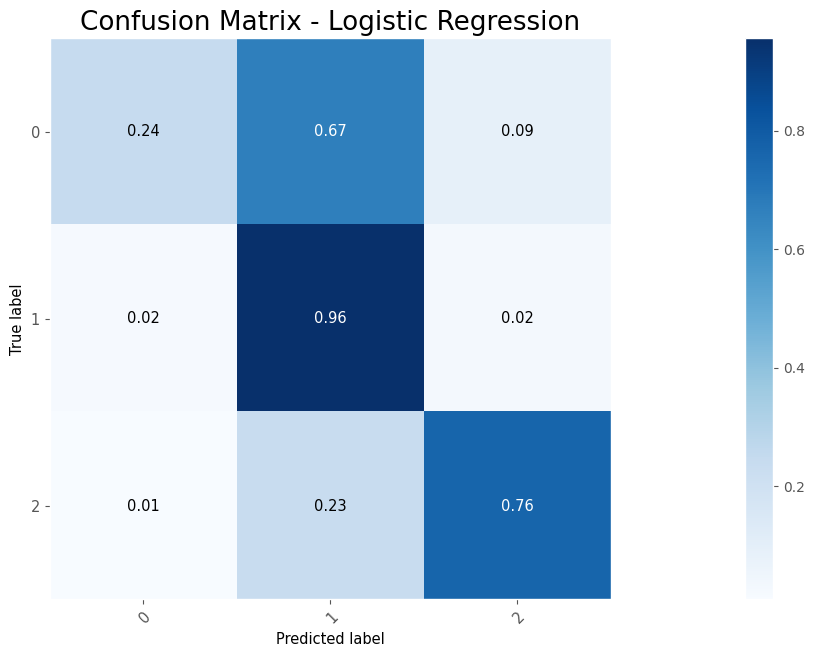

array([[0.24444444, 0.66666667, 0.08888889],
       [0.0194603 , 0.95588998, 0.02464971],
       [0.00840336, 0.2304922 , 0.76110444]])

In [61]:
logreg = LogisticRegression(n_jobs=1, C=1e5)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['saga', 'sag', 'newton-cg', 'lbfgs'],
    'max_iter': [10000]
}


# Perform GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit the grid search on the scaled training data
grid_search.fit(X_train_vect, y_train)

# Get the best model
best_logreg = grid_search.best_estimator_

# Evaluate the best model on the test set
logreg_pred = best_logreg.predict(X_test_vect)
#print("{} \n\n".format(X_test_vect))
# Print the best parameters and accuracy
print("Best params: {}".format(grid_search.best_params_))
print('Accuracy: {:.3f}'.format(accuracy_score(logreg_pred, y_test)))

# Save the best Logistic Regression model
dump(best_logreg, 'LogisticRegression_model.joblib')

# Analysis
precision = precision_score(y_test, logreg_pred, average='weighted')
recall = recall_score(y_test, logreg_pred, average='weighted')
f1 = f1_score(y_test, logreg_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, logreg_pred)

classes = sorted(set(y_test))

print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 Score: {:.3f}".format(f1))
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
print("Classification Report:")
print(classification_report(y_test, logreg_pred, target_names=['class 0', 'class 1', 'class 2']))
plot_confusion_matrix(y_true = y_test, y_pred = logreg_pred, classes=[0, 1, 2], normalize=True, magnify=0.1, use_title="Confusion Matrix - Logistic Regression")

# GPT-2

The OpenAI GPT-2 (Generative Pre-Trained Transformer 2) is a transfomer-based language model. It's a standard model for NLP tasks.

Starting training: epochs - 3, lr - 1e-05, batch size - 32


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.4666576202357969
Epoch 2: Average Loss: 0.31535104067335207
Epoch 3: Average Loss: 0.2527648022398353
Training complete: epochs - 3, lr - 1e-05, batch size - 32
Starting training: epochs - 3, lr - 2e-05, batch size - 32


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.4327464167629519
Epoch 2: Average Loss: 0.2959613393511503
Epoch 3: Average Loss: 0.2362463475144919
Training complete: epochs - 3, lr - 2e-05, batch size - 32
Starting training: epochs - 3, lr - 5e-05, batch size - 32


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.4394380470076876
Epoch 2: Average Loss: 0.2733584694023575
Epoch 3: Average Loss: 0.1888421480844338
Training complete: epochs - 3, lr - 5e-05, batch size - 32
Starting training: epochs - 4, lr - 1e-05, batch size - 32


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.459380547798449
Epoch 2: Average Loss: 0.31325811776783197
Epoch 3: Average Loss: 0.25367461268699937
Epoch 4: Average Loss: 0.19913027522364452
Training complete: epochs - 4, lr - 1e-05, batch size - 32
Starting training: epochs - 4, lr - 2e-05, batch size - 32


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.4320656385693339
Epoch 2: Average Loss: 0.29288863858147973
Epoch 3: Average Loss: 0.22426130080956125
Epoch 4: Average Loss: 0.16300899141633343
Training complete: epochs - 4, lr - 2e-05, batch size - 32
Starting training: epochs - 4, lr - 5e-05, batch size - 32


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.45245850454535214
Epoch 2: Average Loss: 0.27091778281835777
Epoch 3: Average Loss: 0.18412678253145948
Epoch 4: Average Loss: 0.10639805674305065
Training complete: epochs - 4, lr - 5e-05, batch size - 32
Starting training: epochs - 5, lr - 1e-05, batch size - 32


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.4577102864221219
Epoch 2: Average Loss: 0.3139476363396933
Epoch 3: Average Loss: 0.25284547757717873
Epoch 4: Average Loss: 0.20249399232768242
Epoch 5: Average Loss: 0.14698416335102651
Training complete: epochs - 5, lr - 1e-05, batch size - 32
Starting training: epochs - 5, lr - 2e-05, batch size - 32


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.4405756922378655
Epoch 2: Average Loss: 0.29628168930329624
Epoch 3: Average Loss: 0.23263936815783381
Epoch 4: Average Loss: 0.1684115221859106
Epoch 5: Average Loss: 0.11240873173435008
Training complete: epochs - 5, lr - 2e-05, batch size - 32
Starting training: epochs - 5, lr - 5e-05, batch size - 32


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.46557165588582716
Epoch 2: Average Loss: 0.2733691209206177
Epoch 3: Average Loss: 0.18510632945464983
Epoch 4: Average Loss: 0.11188181898361373
Epoch 5: Average Loss: 0.0639164261671061
Training complete: epochs - 5, lr - 5e-05, batch size - 32
Starting training: epochs - 3, lr - 1e-05, batch size - 64


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.48827568840595986
Epoch 2: Average Loss: 0.3266363963484764
Epoch 3: Average Loss: 0.2599844251909564
Training complete: epochs - 3, lr - 1e-05, batch size - 64
Starting training: epochs - 3, lr - 2e-05, batch size - 64


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.4814954192888352
Epoch 2: Average Loss: 0.2998685600536485
Epoch 3: Average Loss: 0.23603386273307184
Training complete: epochs - 3, lr - 2e-05, batch size - 64
Starting training: epochs - 3, lr - 5e-05, batch size - 64


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.5536418554282958
Epoch 2: Average Loss: 0.28821442540614833
Epoch 3: Average Loss: 0.193326653095503
Training complete: epochs - 3, lr - 5e-05, batch size - 64
Starting training: epochs - 4, lr - 1e-05, batch size - 64


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.49213100638120405
Epoch 2: Average Loss: 0.3271653533462555
Epoch 3: Average Loss: 0.2628895026301184
Epoch 4: Average Loss: 0.19982548621032506
Training complete: epochs - 4, lr - 1e-05, batch size - 64
Starting training: epochs - 4, lr - 2e-05, batch size - 64


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.4599138166635267
Epoch 2: Average Loss: 0.3030246488269298
Epoch 3: Average Loss: 0.2371575276217153
Epoch 4: Average Loss: 0.18014133686740552
Training complete: epochs - 4, lr - 2e-05, batch size - 64
Starting training: epochs - 4, lr - 5e-05, batch size - 64


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.5025125026222198
Epoch 2: Average Loss: 0.281110830965542
Epoch 3: Average Loss: 0.1966168788411925
Epoch 4: Average Loss: 0.12428522583457731
Training complete: epochs - 4, lr - 5e-05, batch size - 64
Starting training: epochs - 5, lr - 1e-05, batch size - 64


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.4900239372926374
Epoch 2: Average Loss: 0.3270774746854459
Epoch 3: Average Loss: 0.2593597021795088
Epoch 4: Average Loss: 0.20295808762311934
Epoch 5: Average Loss: 0.15336644375516523
Training complete: epochs - 5, lr - 1e-05, batch size - 64
Starting training: epochs - 5, lr - 2e-05, batch size - 64


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.47172245561115206
Epoch 2: Average Loss: 0.30429753879866295
Epoch 3: Average Loss: 0.23974873225294774
Epoch 4: Average Loss: 0.18162433199824826
Epoch 5: Average Loss: 0.13104490430484855
Training complete: epochs - 5, lr - 2e-05, batch size - 64
Starting training: epochs - 5, lr - 5e-05, batch size - 64


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.5431735965994097
Epoch 2: Average Loss: 0.28907041999120864
Epoch 3: Average Loss: 0.19890625839752535
Epoch 4: Average Loss: 0.123128404107786
Epoch 5: Average Loss: 0.07389133282216086
Training complete: epochs - 5, lr - 5e-05, batch size - 64
Starting training: epochs - 3, lr - 1e-05, batch size - 128


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.5246379596571769
Epoch 2: Average Loss: 0.3455384559208347
Epoch 3: Average Loss: 0.2759916256512365
Training complete: epochs - 3, lr - 1e-05, batch size - 128
Starting training: epochs - 3, lr - 2e-05, batch size - 128


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.5431431306946662
Epoch 2: Average Loss: 0.3311563141884342
Epoch 3: Average Loss: 0.2589511995834689
Training complete: epochs - 3, lr - 2e-05, batch size - 128
Starting training: epochs - 3, lr - 5e-05, batch size - 128


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.6442685627168224
Epoch 2: Average Loss: 0.32695223150714753
Epoch 3: Average Loss: 0.23173122953984046
Training complete: epochs - 3, lr - 5e-05, batch size - 128
Starting training: epochs - 4, lr - 1e-05, batch size - 128


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.5126603601440307
Epoch 2: Average Loss: 0.33868480670836665
Epoch 3: Average Loss: 0.2733262458155232
Epoch 4: Average Loss: 0.2133897352603174
Training complete: epochs - 4, lr - 1e-05, batch size - 128
Starting training: epochs - 4, lr - 2e-05, batch size - 128


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.5762275009386001
Epoch 2: Average Loss: 0.329463374326306
Epoch 3: Average Loss: 0.25256059982122914
Epoch 4: Average Loss: 0.1938086169861978
Training complete: epochs - 4, lr - 2e-05, batch size - 128
Starting training: epochs - 4, lr - 5e-05, batch size - 128


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.6235489120406489
Epoch 2: Average Loss: 0.3157649081560873
Epoch 3: Average Loss: 0.2208108796227363
Epoch 4: Average Loss: 0.14262094327038335
Training complete: epochs - 4, lr - 5e-05, batch size - 128
Starting training: epochs - 5, lr - 1e-05, batch size - 128


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.525117988163425
Epoch 2: Average Loss: 0.34206558091025197
Epoch 3: Average Loss: 0.26896427975546927
Epoch 4: Average Loss: 0.21009603306170432
Epoch 5: Average Loss: 0.14844024021538996
Training complete: epochs - 5, lr - 1e-05, batch size - 128
Starting training: epochs - 5, lr - 2e-05, batch size - 128


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.5761028705104705
Epoch 2: Average Loss: 0.3295031671562502
Epoch 3: Average Loss: 0.2577319760476389
Epoch 4: Average Loss: 0.19507695936387584
Epoch 5: Average Loss: 0.1408253732948534
Training complete: epochs - 5, lr - 2e-05, batch size - 128
Starting training: epochs - 5, lr - 5e-05, batch size - 128


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.638664867993324
Epoch 2: Average Loss: 0.3237379310592528
Epoch 3: Average Loss: 0.22862926202435646
Epoch 4: Average Loss: 0.1477069075790144
Epoch 5: Average Loss: 0.08721262602916648
Training complete: epochs - 5, lr - 5e-05, batch size - 128
Parameter tuning phase ended. Best parameters: epochs - 3, batch size - 32, lr - 1e-05

--- TRAINING WITH BEST PARAMETERS ---
Starting training: epochs - 3, lr - 1e-05, batch size - 32


C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.4619572825729847
Epoch 2: Average Loss: 0.31090536931709895
Epoch 3: Average Loss: 0.2509695390269401
Training complete: epochs - 3, lr - 1e-05, batch size - 32
GPT-2 Accuracy: 0.8622150494250554


C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


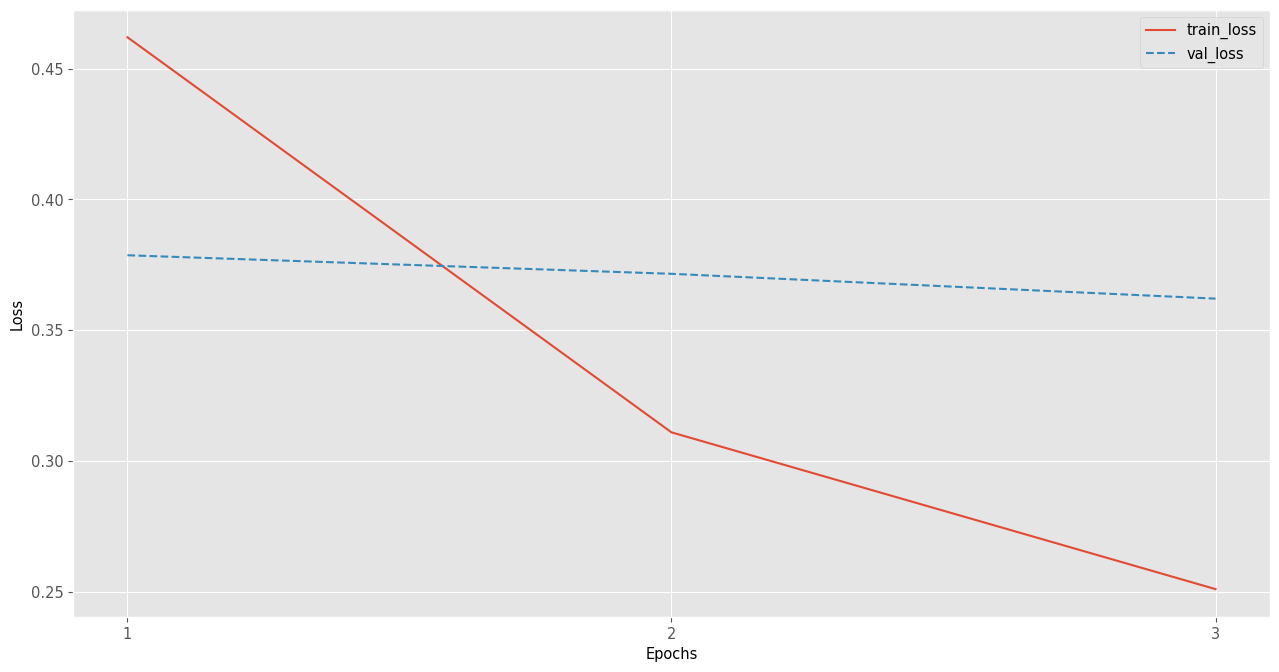

C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


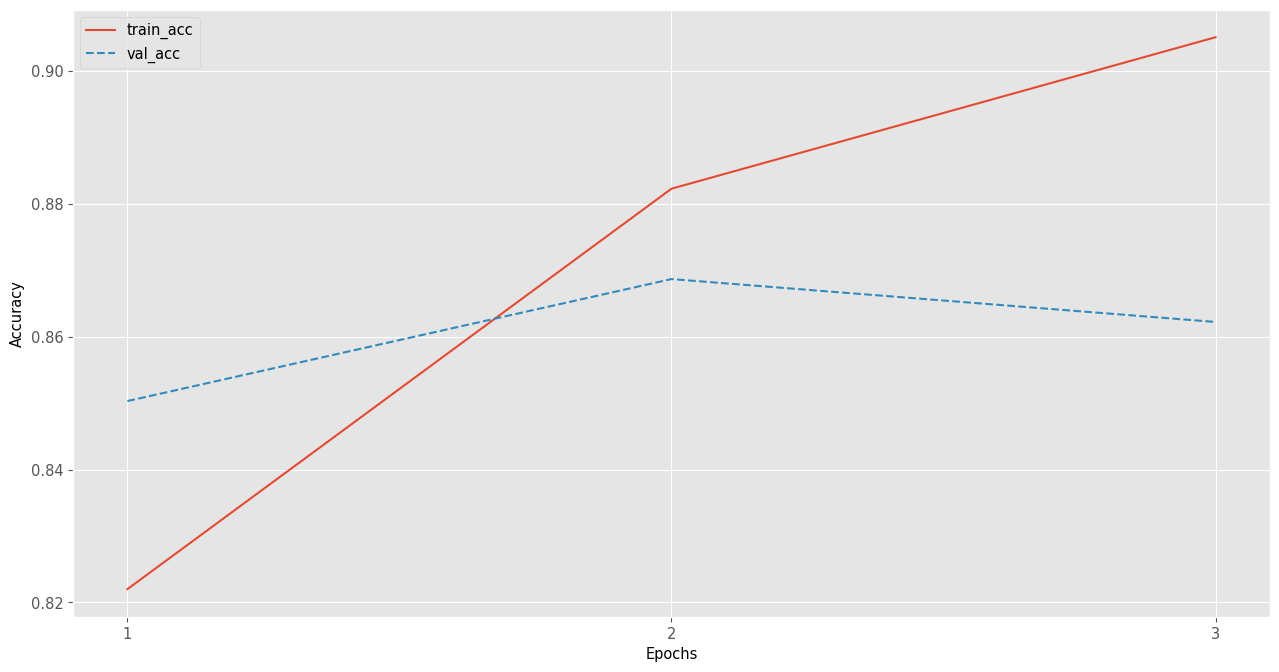

Classification Report:
              precision    recall  f1-score   support

     class 0       0.41      0.26      0.32       290
     class 1       0.90      0.94      0.92      3832
     class 2       0.77      0.72      0.75       835

    accuracy                           0.86      4957
   macro avg       0.70      0.64      0.66      4957
weighted avg       0.85      0.86      0.85      4957

Normalized confusion matrix


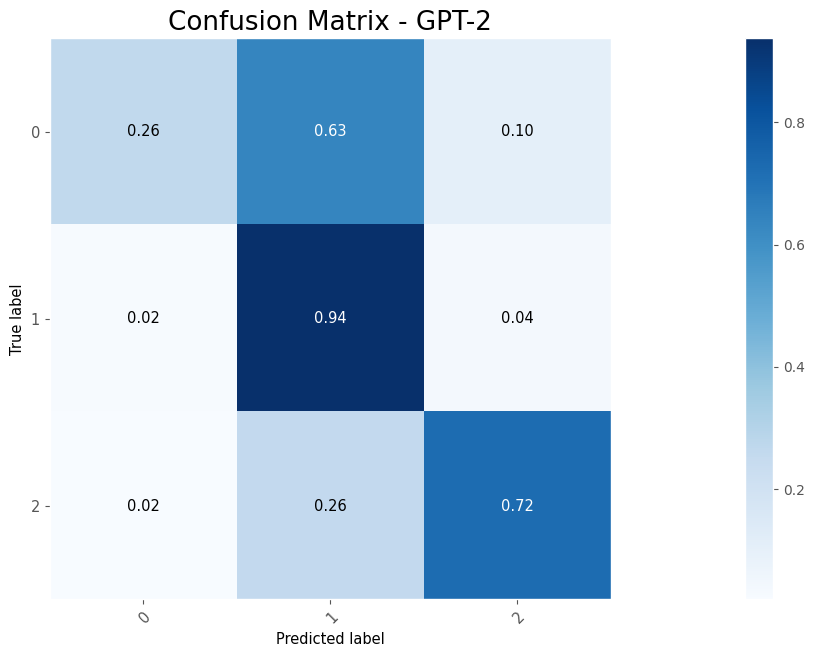

array([[0.26206897, 0.63448276, 0.10344828],
       [0.02400835, 0.93763048, 0.03836117],
       [0.01916168, 0.25628743, 0.7245509 ]])

In [10]:


max_length = 32
tokenized_texts_train = tokenizer_gpt2(list(X_train), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
tokenized_texts_test = tokenizer_gpt2(list(X_test), padding=True, truncation=True, max_length=max_length, return_tensors='pt')


# Save tokenized data to disk
torch.save(tokenized_texts_train, 'tokenized_texts_train_gpt2.pth')  
torch.save(tokenized_texts_test, 'tokenized_texts_test_gpt2.pth')

labels_train = torch.tensor(list(y_train)).to(device)
labels_test = torch.tensor(list(y_test)).to(device)

train_dataset_gpt2 = TensorDataset(tokenized_texts_train.input_ids, tokenized_texts_train.attention_mask, labels_train)
test_dataset_gpt2 = TensorDataset(tokenized_texts_test.input_ids, tokenized_texts_test.attention_mask, labels_test)

model_config_gpt2 = GPT2Config.from_pretrained('gpt2', num_labels=3, pad_token_id=tokenizer_gpt2.pad_token_id)

def train_gpt2(model, epochs, lr, batch_size, device, save_model=False):
    all_loss_gpt2 = {'train_loss':[], 'val_loss':[]}
    all_acc_gpt2 = {'train_acc':[], 'val_acc':[]}
    train_loader_gpt2 = DataLoader(train_dataset_gpt2, batch_size=batch_size, shuffle=True)
    test_loader_gpt2 = DataLoader(test_dataset_gpt2, batch_size=batch_size, shuffle=False)
    optimizer = AdamW(model.parameters(), lr=lr, no_deprecation_warning=True)
    print(f"Starting training: epochs - {epochs}, lr - {lr}, batch size - {batch_size}")
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        total_correct_train = 0
        total_samples_train = 0
        for batch in train_loader_gpt2:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            writer.add_scalar("Loss/train_gpt2", loss, epoch)

            total_loss += loss.item()

            _, predicted_train = torch.max(outputs.logits, 1)
            total_samples_train += labels.size(0)
            total_correct_train += (predicted_train == labels).sum().item()

            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}: Average Loss: {total_loss / len(train_loader_gpt2)}')
        all_loss_gpt2['train_loss'].append(total_loss / len(train_loader_gpt2))
        all_acc_gpt2['train_acc'].append(total_correct_train / total_samples_train)
        model.eval()
        total_val_loss = 0
        total_correct_val = 0
        total_samples_val = 0
        with torch.no_grad():
            for batch in test_loader_gpt2:
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss = outputs.loss

                total_val_loss += val_loss.item()

                _, predicted_val = torch.max(outputs.logits, 1)
                total_samples_val += labels.size(0)
                total_correct_val += (predicted_val == labels).sum().item()
        
        all_loss_gpt2['val_loss'].append(total_val_loss / len(test_loader_gpt2))
        all_acc_gpt2['val_acc'].append(total_correct_val / total_samples_val)
        writer.add_scalar("Loss/val_gpt2", total_val_loss / len(test_loader_gpt2), epoch)

        if save_model:
            torch.save(model.state_dict(), 'gpt2_model.pth') # saving gpt-2 model
        writer.flush()
    print(f"Training complete: epochs - {epochs}, lr - {lr}, batch size - {batch_size}")
    return model, all_loss_gpt2, all_acc_gpt2

param_grid = {
    'batch_size': [32, 64],
    'epochs': [2, 3, 4],
    'lr': [1e-5, 2e-5]
}
best_params = None
best_accuracy = 0.0

for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for lr in param_grid['lr']:
            model_gpt2 = GPT2ForSequenceClassification(model_config_gpt2).to(device)
            model_gpt2.resize_token_embeddings(len(tokenizer_gpt2))

            model_gpt2, all_loss_gpt2, all_acc_gpt2 = train_gpt2(model=model_gpt2, epochs=epochs, batch_size=batch_size, lr=lr, device=device)

            val_accuracy = all_acc_gpt2['val_acc'][-1]

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'batch_size': batch_size, 'epochs': epochs, 'lr': lr}

best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']
best_learning_rate = best_params['lr']

print(f"Parameter tuning phase ended. Best parameters: epochs - {best_epochs}, batch size - {best_batch_size}, lr - {best_learning_rate}")
print("\n--- TRAINING WITH BEST PARAMETERS ---")
# Train the model with the best parameters
model_gpt2 = GPT2ForSequenceClassification(model_config_gpt2).to(device)
model_gpt2.resize_token_embeddings(len(tokenizer_gpt2))
optimizer_gpt2 = AdamW(model_gpt2.parameters(), lr=best_learning_rate)

model_gpt2, all_loss_gpt2, all_acc_gpt2 = train_gpt2(model=model_gpt2,  epochs=best_epochs, batch_size=best_batch_size, lr=best_learning_rate, device=device, save_model=True)

model_gpt2.eval()
predicted_labels_gpt2 = []
true_labels_gpt2 = []

test_loader_gpt2 = DataLoader(test_dataset_gpt2, batch_size=best_batch_size, shuffle=False)

with torch.no_grad():
    for batch in test_loader_gpt2:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model_gpt2(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predicted_labels_gpt2.extend(torch.argmax(logits, axis=1).tolist()) #Extract the max logits value and convert from pytorch to a pyList
        true_labels_gpt2.extend(labels.tolist())

accuracy_gpt2 = accuracy_score(true_labels_gpt2, predicted_labels_gpt2)
print(f'GPT-2 Accuracy: {accuracy_gpt2}')

plot_dict(all_loss_gpt2, use_xlabel='Epochs', use_ylabel='Loss', use_linestyles=['-', '--'])
plot_dict(all_acc_gpt2, use_xlabel='Epochs', use_ylabel='Accuracy', use_linestyles=['-', '--'])

print("Classification Report:")
print(classification_report(true_labels_gpt2, predicted_labels_gpt2, target_names=['class 0', 'class 1', 'class 2']))

plot_confusion_matrix(y_true=true_labels_gpt2, y_pred=predicted_labels_gpt2, classes=[0, 1, 2], normalize=True, magnify=0.1, use_title="Confusion Matrix - GPT-2")

# BERT

BERT (Bidirectional Encoder Representations from Transformers) was developed by Google researchers.

In [5]:
tokenized_texts_train_bert = tokenizer_bert(list(X_train), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
tokenized_texts_test_bert = tokenizer_bert(list(X_test), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Save tokenized data to disk
torch.save(tokenized_texts_train_bert, 'tokenized_texts_train_bert.pth')  
torch.save(tokenized_texts_test_bert, 'tokenized_texts_test_bert.pth')

train_dataset_bert = TensorDataset(tokenized_texts_train_bert.input_ids, tokenized_texts_train_bert.attention_mask, labels_train)
test_dataset_bert = TensorDataset(tokenized_texts_test_bert.input_ids, tokenized_texts_test_bert.attention_mask, labels_test)

def train_bert(model, epochs, lr, batch_size, device, save_model=False):
    all_loss_bert = {'train_loss':[], 'val_loss':[]}
    all_acc_bert = {'train_acc':[], 'val_acc':[]}
    train_loader_bert = DataLoader(train_dataset_bert, batch_size=batch_size, shuffle=True)
    test_loader_bert = DataLoader(test_dataset_bert, batch_size=batch_size, shuffle=False)
    optimizer = AdamW(model.parameters(), lr=lr, no_deprecation_warning=True)
    print(f"Starting training: epochs - {epochs}, lr - {lr}, batch size - {batch_size}")
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        total_correct_train = 0
        total_samples_train = 0
        for batch in train_loader_bert:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            writer.add_scalar("Loss/train_bert", loss, epoch)
            total_loss += loss.item()

            _, predicted_train = torch.max(outputs.logits, 1)
            total_samples_train += labels.size(0)
            total_correct_train += (predicted_train == labels).sum().item()
            
            loss.backward()
            optimizer.step()
        avg_loss = total_loss / len(train_loader_bert)
        print(f'Epoch {epoch + 1}: Average Loss: {avg_loss}')
        all_loss_bert['train_loss'].append(total_loss / len(train_loader_bert))
        all_acc_bert['train_acc'].append(total_correct_train / total_samples_train)
        model.eval()
        total_val_loss = 0
        total_correct_val = 0
        total_samples_val = 0
        with torch.no_grad():
            for batch in test_loader_bert:
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss = outputs.loss

                total_val_loss += val_loss.item()

                _, predicted_val = torch.max(outputs.logits, 1)
                total_samples_val += labels.size(0)
                total_correct_val += (predicted_val == labels).sum().item()

        all_loss_bert['val_loss'].append(total_val_loss / len(test_loader_bert))
        all_acc_bert['val_acc'].append(total_correct_val / total_samples_val)
        writer.add_scalar("Loss/val_bert", total_val_loss / len(test_loader_bert), epoch)

        if save_model:
            torch.save(model.state_dict(), 'bert_model.pth') # saving bert model
        writer.flush()
    print(f"Training complete: epochs - {epochs}, lr - {lr}, batch size - {batch_size}")
    return model, all_loss_bert, all_acc_bert

param_grid = {
    'batch_size': [32, 64],
    'epochs': [2, 3, 4],
    'lr': [1e-5, 2e-5]
}
best_params = None
best_accuracy = 0.0

for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for lr in param_grid['lr']:
            model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)
            model_bert.resize_token_embeddings(len(tokenizer_bert))

            model_bert, all_loss_bert, all_acc_bert = train_bert(model=model_bert, epochs=epochs, batch_size=batch_size, lr=lr, device=device)

            val_accuracy = all_acc_bert['val_acc'][-1]

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'batch_size': batch_size, 'epochs': epochs, 'lr': lr}

best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']
best_learning_rate = best_params['lr']

print(f"Parameter tuning phase ended. Best parameters: epochs - {best_epochs}, batch size - {best_batch_size}, lr - {best_learning_rate}")
print("\n--- TRAINING WITH BEST PARAMETERS ---")
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)
model_bert.resize_token_embeddings(len(tokenizer_bert))
optimizer_bert = AdamW(model_bert.parameters(), lr=best_learning_rate, no_deprecation_warning=True)

model_bert, all_loss_bert, all_acc_bert = train_bert(model=model_bert, epochs=best_epochs, batch_size=best_batch_size, lr=best_learning_rate, device=device, save_model=True)

model_bert.eval()
predicted_labels_bert = []
true_labels_bert = []

test_loader_bert = DataLoader(test_dataset_bert, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for batch in test_loader_bert:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels_bert.extend(torch.argmax(logits, axis=1).tolist())
        true_labels_bert.extend(labels.tolist())

accuracy_bert = accuracy_score(true_labels_bert, predicted_labels_bert)
print(f'BERT Accuracy: {accuracy_bert}')

plot_dict(all_loss_bert, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
plot_dict(all_acc_bert, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

print("Classification Report:")
print(classification_report(true_labels_bert, predicted_labels_bert, target_names=['class 0', 'class 1', 'class 2']))

plot_confusion_matrix(y_true=true_labels_bert, y_pred=predicted_labels_bert, classes=[0, 1, 2], normalize=True, magnify=0.1, use_title="Confusion Matrix - BERT")


NameError: name 'max_length' is not defined

# Testing on some sentences

In [65]:
input_sentences = ["Fuck you and your entire country stupid French","Hi how are you?","weather is wonderful today", "fucking bitch you are so stupid", "go back to africa nigga", "stupid autistic nigga", "you are a beatiful butterfly", "The dishes at the belzoni restourant are good", "Stupid goat", "I'm dreaming that a bomb fall in your city", "Son of bitch", "love you son of a bitch"]

messages = ["hate speech", "offensive language", "message approved"]

preprocessed_input_sentences = clean_text(input_sentences)
preprocessed_input_sentences = remove_stopwords(preprocessed_input_sentences)
preprocessed_input_sentences = apply_stemming(preprocessed_input_sentences)
preprocessed_input_sentences = apply_lemmatization(preprocessed_input_sentences)


#model_gpt2.load_state_dict(torch.load('gpt2_model.pth', map_location = device))  # Load pre-trained GPT-2 model from disk
#model_bert.load_state_dict(torch.load('bert_model.pth', map_location = device))  # Load pre-trained BERT model from disk
model_LR = load('LogisticRegression_model.joblib')

with open("accuracy_bert.txt", "r") as file:
    accuracy_bert = float(file.read())

with open("accuracy_gpt2.txt", "r") as file:
    accuracy_gpt2 = float(file.read())

with open("accuracy_LR.txt", "r") as file:
    accuracy_LR = float(file.read())


# LOGISTIC REGRESSION

# Transform the input sentences
input_LR = vectorizer.transform(preprocessed_input_sentences)

predicted_classes_LR = []
for row in input_LR:
    # Reshape the row to be a 2D array
    row = row.reshape(1, -1)

    # Make prediction
    predicted_class_LR = model_LR.predict(row)
    predicted_classes_LR.append(predicted_class_LR)



for original_sentence, input_sentence, row in zip(input_sentences, preprocessed_input_sentences, input_LR):
    print(f"Input: {original_sentence}")

    # LOGISTIC REGRESSION
    # Reshape the row to be a 2D array
    row = row.reshape(1, -1)

    # Make prediction
    predicted_class_LR = (model_LR.predict(row))[0]
    print(f"LOGISTIC REGRESSION: Response: Class {predicted_class_LR} - {messages[predicted_class_LR]}")

    
    # BERT

    # Tokenize input for BERT
    input_ids_bert = tokenizer_bert.encode(input_sentence, return_tensors='pt').to(device)
    attention_mask_bert = torch.ones_like(input_ids_bert).to(device)

    # Generate output for BERT
    with torch.no_grad():
        outputs_bert = model_bert(input_ids_bert, attention_mask=attention_mask_bert)
        predicted_class_bert = torch.argmax(outputs_bert.logits, dim=1).item()

    print(f"BERT Response: Class {predicted_class_bert} - {messages[predicted_class_bert]}")

    # GPT-2

    # Tokenize input for GPT-2
    input_ids_gpt2 = tokenizer_gpt2.encode(input_sentence, return_tensors='pt').to(device)
    attention_mask_gpt2 = torch.ones_like(input_ids_gpt2).to(device)

    # Generate output for GPT-2
    with torch.no_grad():
        outputs_gpt2 = model_gpt2(input_ids_gpt2, attention_mask=attention_mask_gpt2)
        predicted_class_gpt2 = torch.argmax(outputs_gpt2.logits, dim=1).item()

    print(f"GPT-2 Response: Class {predicted_class_gpt2} - {messages[predicted_class_gpt2]}\n")

    
    

    # Multi-agent system: GPT-2 and BERT cooperate to guarantee a correct solution, based on their accuracy
    predicted_class_coop = (predicted_class_bert * accuracy_bert + predicted_class_gpt2 * accuracy_gpt2 + predicted_class_LR * accuracy_LR) / (accuracy_gpt2 + accuracy_bert + accuracy_LR)
    print(f"Cooperative result: Class {predicted_class_coop:.3f} - {messages[round(predicted_class_coop)]}\n")



Input: Fuck you and your entire country stupid French
LOGISTIC REGRESSION: Response: Class 1 - offensive language
BERT Response: Class 0 - hate speech
GPT-2 Response: Class 2 - message approved

Cooperative result: Class 0.995 - offensive language

Input: Hi how are you?
LOGISTIC REGRESSION: Response: Class 1 - offensive language
BERT Response: Class 0 - hate speech
GPT-2 Response: Class 0 - hate speech

Cooperative result: Class 0.333 - hate speech

Input: weather is wonderful today
LOGISTIC REGRESSION: Response: Class 2 - message approved
BERT Response: Class 0 - hate speech
GPT-2 Response: Class 1 - offensive language

Cooperative result: Class 0.997 - offensive language

Input: fucking bitch you are so stupid
LOGISTIC REGRESSION: Response: Class 1 - offensive language
BERT Response: Class 0 - hate speech
GPT-2 Response: Class 2 - message approved

Cooperative result: Class 0.995 - offensive language

Input: go back to africa nigga
LOGISTIC REGRESSION: Response: Class 1 - offensive 

# Plot

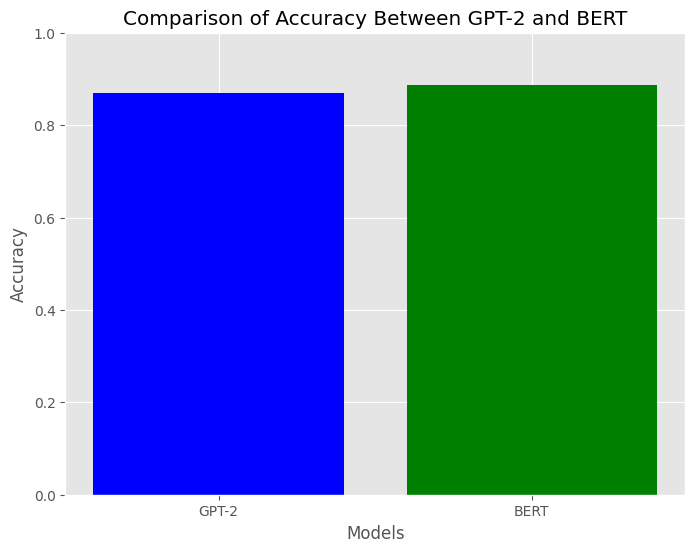

In [8]:
models = ['GPT-2', 'BERT']
accuracies = [accuracy_gpt2, accuracy_bert]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Between GPT-2 and BERT')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.show()